# **Predicción de precios de casas**

## **Problema**
Pídale a un comprador de vivienda que describa la casa de sus sueños, y probablemente no comenzaráconlaalturadeltechodelsótanoola proximidadaunferrocarrileste-oeste.Peroel conjunto de datos de esta competencia en el patio de recreo demuestra que influye mucho más en las negociaciones de precios que la cantidad de dormitorios o una valla blanca.

Con 79 variables explicativas que describen (casi) todos los aspectos de las casas residenciales en Ames, Iowa, esta competencia lo desafía a predecir el precio final de cada casa.

## **Objetivo**
Obtener Precios de Casas usando métodos de Boosting Regresión
## **Métrica**
La métrica usada será RMSE

### Importando librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

### Leyendo los archivos csv de train y test

In [2]:
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

### Seleccionando columnas que tienen mayores celdas vacías para eliminarlas de los datos de train y test

In [3]:
drop_columns = train.isnull().sum()[train.isnull().sum() > train.shape[0]/2]
drop_columns = drop_columns.index.to_list()

In [4]:
train_new = train.drop(drop_columns, axis =1)
test_new = test.drop(drop_columns, axis=1)

In [5]:
train_new.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

<Figure size 2000x1000 with 0 Axes>

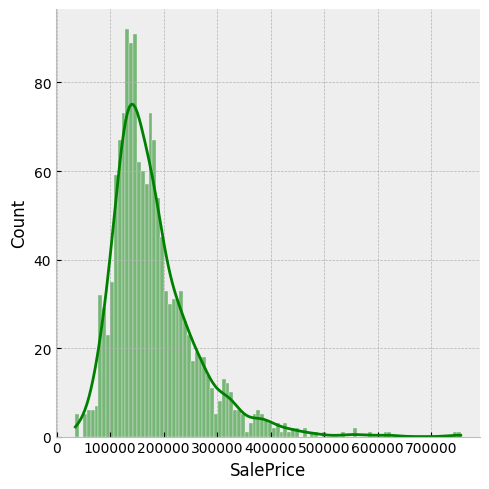

In [6]:
plt.figure(figsize=(20,10))
sns.displot(data=train_new, x='SalePrice', color='g', bins=100, kde=True)
plt.show()

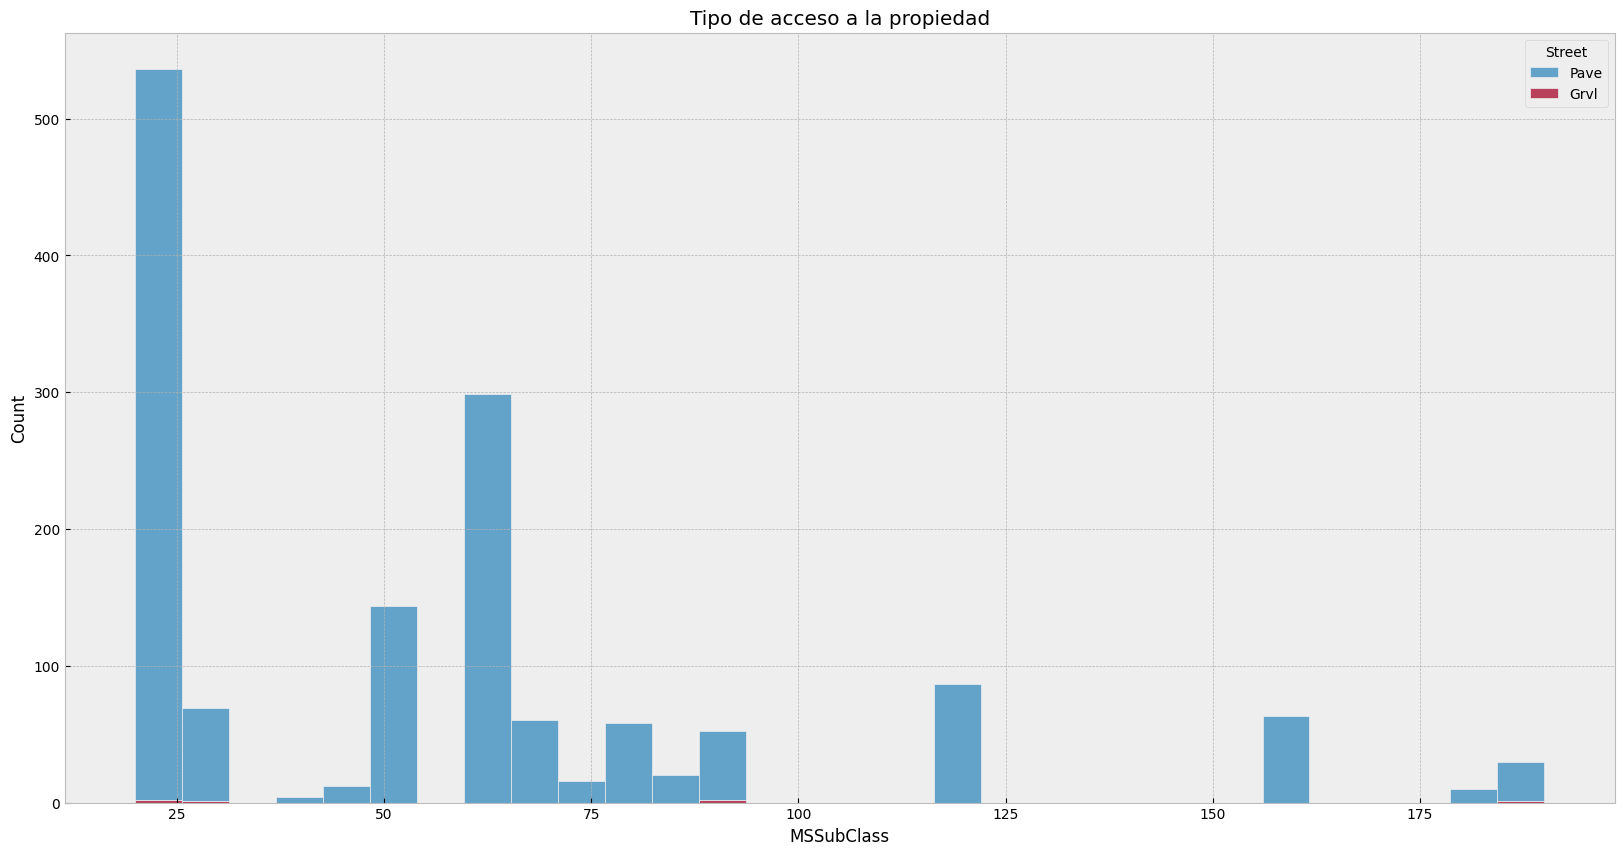

In [7]:
plt.figure(figsize=(20,10))
sns.histplot(data=train_new, x='MSSubClass', hue='Street', bins=30, multiple='stack')
plt.title('Tipo de acceso a la propiedad')
plt.show()

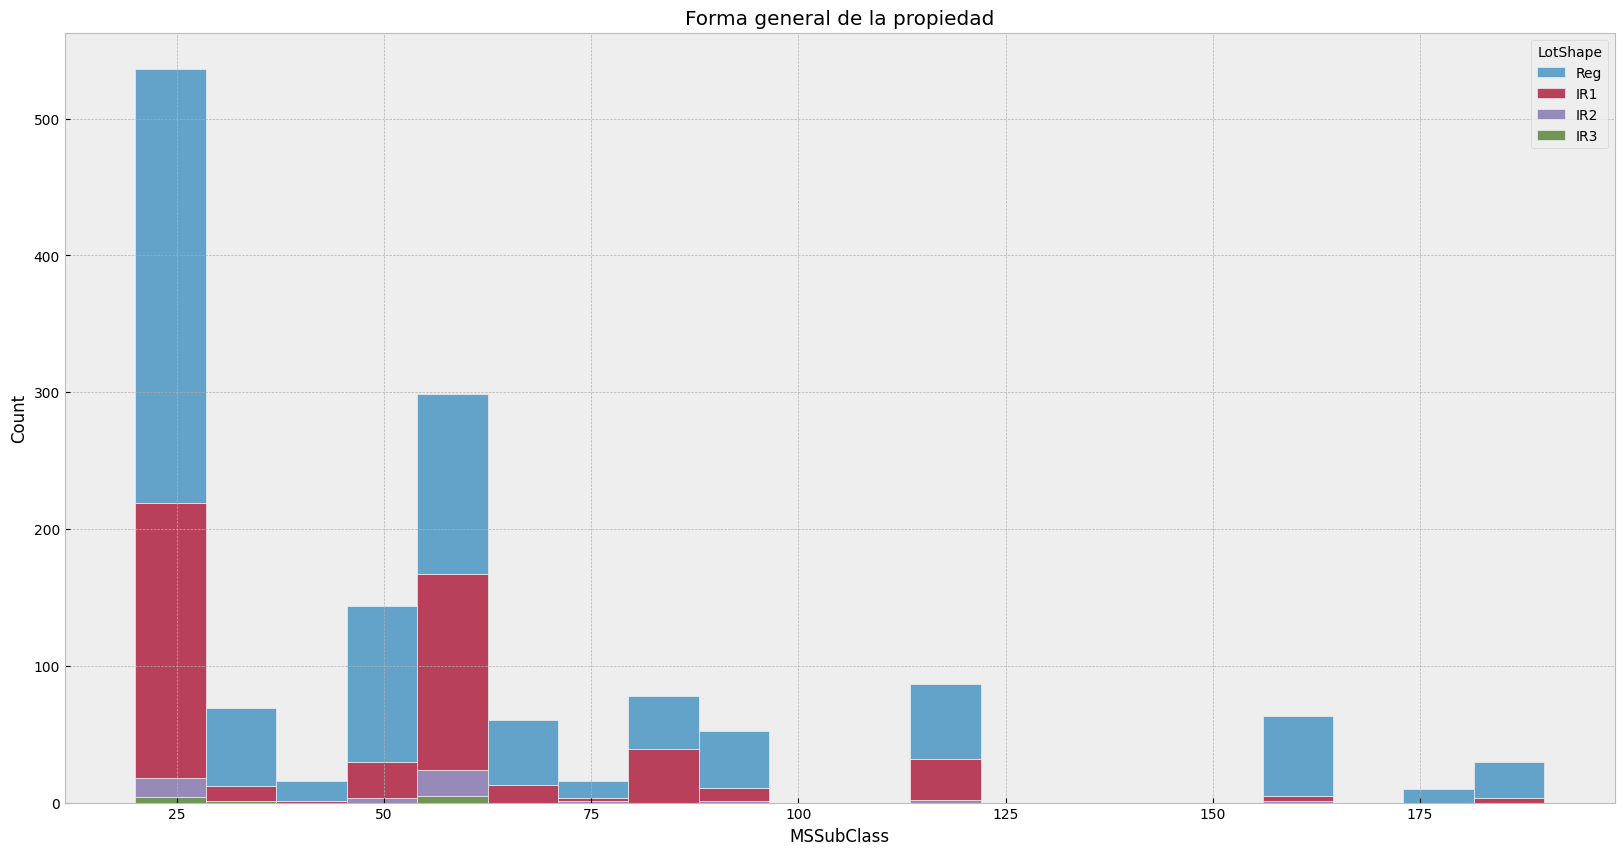

In [8]:
plt.figure(figsize=(20,10))
sns.histplot(data=train_new, x='MSSubClass', hue='LotShape', multiple='stack')
plt.title('Forma general de la propiedad')
plt.show()

In [9]:
train_new['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

### Seleccionando columnas según su tipo de variable

In [10]:
cat = test_new.select_dtypes(include='object').columns.to_list()
num = test_new.select_dtypes(exclude='object').columns.to_list()
num.remove('Id')
target = train_new.columns.to_list()[-1]

### Preprocesando la data

In [11]:
X = train_new[cat + num]
y = train_new[target]

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [13]:
impute_num = SimpleImputer(strategy='mean')
impute_cat = SimpleImputer(strategy='most_frequent')
impute_num.fit(X[num])
impute_cat.fit(X[cat])
X_num = impute_num.transform(X[num])
X_num = pd.DataFrame(X_num, columns=[num])
X_cat = impute_cat.transform(X[cat])
X_cat = pd.DataFrame(X_cat, columns=[cat])

In [14]:
X_processed = pd.concat([X_cat, X_num], axis=1)

### Modelando

In [15]:
data = pd.concat([y, X_processed], axis=1)

In [16]:
from pycaret.regression import *

In [17]:
dataset = setup(data = data, 
                target = target,
                session_id = 123,
                silent = True)

,Description,Value
0,session_id,123
1,Target,SalePrice
2,Original Data,"(1460, 76)"
3,Missing Values,False
4,Numeric Features,35
5,Categorical Features,40
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 264)"


In [18]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,15371.8872,793860146.7958,27227.5742,0.8840,0.1267,0.0885,2.3320
gbr,Gradient Boosting Regressor,17121.6813,829134044.4545,27935.1738,0.8760,0.1370,0.0994,0.0540
lightgbm,Light Gradient Boosting Machine,17609.9798,1011864510.0902,30942.5195,0.8493,0.1451,0.1014,0.0220
xgboost,Extreme Gradient Boosting,18477.4117,1101592981.9800,31335.9813,0.8418,0.1525,0.1081,0.0880
rf,Random Forest Regressor,18828.7907,1093446525.3706,32136.7949,0.8383,0.1531,0.1101,0.1260
et,Extra Trees Regressor,18859.0829,1164869548.7489,32863.4760,0.8321,0.1512,0.1095,0.1270
ada,AdaBoost Regressor,25511.2056,1378452673.7194,36528.5847,0.7920,0.2054,0.1663,0.0360
ridge,Ridge Regression,20348.5428,1498072593.0424,36037.6456,0.7751,0.1925,0.1230,0.0160
omp,Orthogonal Matching Pursuit,19472.2944,1462090923.1686,35646.1660,0.7746,0.1897,0.1172,0.0970
llar,Lasso Least Angle Regression,19590.1611,1566041729.9506,36208.7542,0.7593,0.1899,0.1202,0.1650


In [19]:
best

In [20]:
tune_best = tune_model(estimator = best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22648.8883,2105928951.6703,45890.4015,0.7428,0.1885,0.1275
1,18380.5215,991292565.3900,31484.7990,0.8453,0.1342,0.0973
2,13963.4358,347307946.8148,18636.1999,0.9248,0.1233,0.0912
3,16761.9666,667856803.2667,25842.9256,0.8713,0.1275,0.0952
4,20511.6815,1373770396.0984,37064.4088,0.8603,0.1845,0.1320
5,18160.7546,1098660648.0518,33146.0503,0.8478,0.1373,0.1016
6,18284.9893,729589712.8917,27010.9184,0.8452,0.1242,0.0985
7,15223.3050,452498893.5556,21272.0214,0.9336,0.1283,0.0928
8,21444.2054,1404753906.0444,37480.0468,0.7903,0.1689,0.1240


In [21]:
tune_best

In [22]:
final_model = finalize_model(estimator = tune_best)

In [23]:
save_model(final_model, '../model/model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='SalePrice',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='SalePrice')),
                 ('fix_perfect', Remove_100(target='SalePrice')),
                 ('clean_names', Clean_Colum_Names()),
           

### Predicciones 

In [24]:
X_test = test_new[num + cat]

In [25]:
X_test_num = impute_num.transform(X_test[num])
X_test_cat = impute_cat.transform(X_test[cat])
X_test_num = pd.DataFrame(X_test_num, columns = [num])
X_test_cat = pd.DataFrame(X_test_cat, columns = [cat])

In [26]:
X_test_processed = pd.concat([X_test_cat, X_test_num], axis=1)

In [27]:
model_load = load_model('../model/model')

Transformation Pipeline and Model Successfully Loaded


In [28]:
predictions = predict_model(model_load, data=X_test_processed)

In [29]:
predictions

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Label
0,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,122521.861035
1,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,146359.455091
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,185599.351831
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,360.0,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0,181378.423923
4,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,0.0,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0,181754.846200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,80432.144899
1455,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,...,0.0,24.0,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,87126.929512
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,474.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,169181.723585
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,80.0,32.0,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,116833.136969


### Interpretabilidad de modelos con SHAP

In [30]:
import shap
import catboost 
from catboost import *
shap.initjs()

In [31]:
explainer = shap.TreeExplainer(model_load)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>